# **NLP Assignment 4: LLM Applications**

Welcome to this assignment! In this task, you will learn how to build **LLM applications from the ground up** using the **LangChain framework** — a widely adopted and industry-standard toolkit for developing AI-driven applications.

---

## Preparation

Before starting the assignment, it is **strongly recommended** that you:

- Review the provided manual thoroughly.
- Attempt the preliminary exercises to become familiar with LangChain’s concepts and syntax.

Working through these exercises independently will help you build a **solid foundation** in LLM application development and prepare you for real-world use cases in research and industry.

---

## Guidelines

- <span style="color:green">**LCEL Syntax:**</span> You must use LangChain’s **LCEL syntax** for every task.  
- <span style="color:green">**Library Consistency:**</span> Use the same libraries and functions as demonstrated in the manual for Parts 1 and 2. While alternatives exist, using them may indicate a lack of understanding of the core material.  
- <span style="color:green">**Context Engineering:**</span> Starting from Part 1, Task 1, all chains must follow the principles of **Context Engineering using System Messages**, as detailed in the manual. Failure to adhere will result in a loss of marks.  
- <span style="color:green">**Reflective Questions:**</span> All reflective questions must be completed independently. The use of AI tools for these questions is strictly prohibited.

# **Part 1: Building LLM pipelines**

![LangChain Logo](figs/LangChain_logo.png)

# **Introduction to LangChain**

### Setting up Gemini's API key

Let's start by connecting to Gemini. You’ll need an API key from Google for this.

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import glob
import os, getpass
from dotenv import load_dotenv
import pandas as pd
import json
import time
from pprint import pprint

from datasets import load_dataset

from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from transformers import BertTokenizer, BertModel
from langchain_chroma import Chroma
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.prompts import PromptTemplate, ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser, JsonOutputParser
from langchain.tools import tool
from langchain.agents import create_agent
from langchain_core.messages import HumanMessage
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_core.runnables import RunnableMap, RunnablePassthrough

load_dotenv()
if "GOOGLE_API_KEY" not in os.environ:
    os.environ["GOOGLE_API_KEY"] = getpass.getpass("Enter your Google AI API key: ")

MODEL_NAME = "gemini-2.5-flash"  # or, feel free to use any LLM here
llm = ChatGoogleGenerativeAI(model=MODEL_NAME, temperature=0)
parser = StrOutputParser()

In [16]:
# From the manual, test the code samples here. Write code on your own to grasp the core concept.
prompt = ChatPromptTemplate.from_template("Tell me a funny joke. The joke must be related to {pakistani_politician} Its okay to make fun of politicians! Make it quick, snappy and witty")


chain = prompt | llm | parser

In [ ]:
## Invoke a chain that prompts the LLM to write a funny joke. The top 3 funniest jokes in the class would get a free cookie from me :)
message = chain.invoke({"pakistani_politician": "Nawaz Sharif"})

print(message)

What's Nawaz Sharif's favorite cure for political pressure?

A first-class ticket to London for "medical treatment"!


## Task 1: Prompt Engineering



##### Converting Unstructured Data to a Structured Format
We'll be dealing with a common problem that almost all data scientists face. How to convert unstructured data into meaningful data that can be easily processed? LLMs can be used for this task to convert textual data to a JSON object.

Use the data from this Kaggle dataset for this task:
[Resume Dataset](https://www.kaggle.com/datasets/gauravduttakiit/resume-dataset)

Your goal is to convert each resume in this dataset to a JSON object, which contains the following information:

- candidate_name 
- candidate_skills (a list of relevant skills)
- candidate_experience: (candidate experience in years)
- candidate_profession

You have to do so through **Zero-Shot, One-Shot and Few-Shot Prompting**

For this problem:
- The Sample Inputs can be found under `datasets/part1/task1/resumes`
- The Sample Outputs are in the JSON file `datasets/part1/task1/resume_outputs.json`

In [17]:
# load the sample inputs
RESUMES_PATH = "datasets/part1/task1/resumes"

resume_files = glob.glob(f"{RESUMES_PATH}/*.txt")
sample_resumes = []
for file_path in resume_files:
    with open(file_path, "r", encoding="utf-8") as f:
        sample_resumes.append(f.read())

In [ ]:
sample_resumes

['**Resume 4: Data Analyst**\n\n**Jessica Park**\nChicago, IL | (555) 987-6543 | jessica.park@email.com | linkedin.com/in/jessicapark\n\n**Summary**\nAnalytical and detail-oriented Data Analyst with 2 years of experience transforming complex datasets into actionable insights. Proficient in SQL, data visualization, and statistical analysis. Passionate about using data to drive business strategy and improve operational efficiency.\n\n**Professional Experience**\n\n*Data Analyst*, Retail Insights Corp., Chicago, IL | 2022 – Present\n*   Wrote complex SQL queries to extract and analyze sales, customer, and inventory data from a centralized data warehouse.\n*   Created interactive Tableau dashboards for the executive team, tracking KPIs and identifying sales trends, which contributed to a 15% reduction in excess inventory.\n*   Performed A/B test analysis for marketing campaigns, providing recommendations that improved conversion rates by 8%.\n*   Assisted in building and maintaining ETL pi

In [18]:
# load dataset from Kaggle
KAGGLE_RESUME_PATH = "datasets/part1/task1/kaggle_resumes/UpdatedResumeDataSet.csv"

resumes_df = pd.read_csv(KAGGLE_RESUME_PATH)

resumes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 962 entries, 0 to 961
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  962 non-null    object
 1   Resume    962 non-null    object
dtypes: object(2)
memory usage: 15.2+ KB


In [19]:
resumes_df

,Category,Resume
0,Data Science,Skills * Programming Languages: Python (pandas...
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...
2,Data Science,"Areas of Interest Deep Learning, Control Syste..."
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...
4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab..."
...,...,...
957,Testing,Computer Skills: â¢ Proficient in MS office (...
958,Testing,â Willingness to accept the challenges. â ...
959,Testing,"PERSONAL SKILLS â¢ Quick learner, â¢ Eagerne..."
960,Testing,COMPUTER SKILLS & SOFTWARE KNOWLEDGE MS-Power ...


In [20]:
# LLM generated batch iterator
# using batches for less requests
resumes_df_small = resumes_df.sample(n=100, random_state=42)

def batch_iterator(df, batch_size):
    """Yield batches of rows from a DataFrame."""
    for start in range(0, len(df), batch_size):
        yield df.iloc[start:start + batch_size]

# # Example usage:
batch_size = 10
for batch in batch_iterator(resumes_df, batch_size):
    # Process each batch (e.g., send to LLM, print, etc.)
    print(batch)
    break

       Category                                             Resume
0  Data Science  Skills * Programming Languages: Python (pandas...
1  Data Science  Education Details \r\nMay 2013 to May 2017 B.E...
2  Data Science  Areas of Interest Deep Learning, Control Syste...
3  Data Science  Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...
4  Data Science  Education Details \r\n MCA   YMCAUST,  Faridab...
5  Data Science  SKILLS C Basics, IOT, Python, MATLAB, Data Sci...
6  Data Science  Skills â¢ Python â¢ Tableau â¢ Data Visuali...
7  Data Science  Education Details \r\n B.Tech   Rayat and Bahr...
8  Data Science  Personal Skills â¢ Ability to quickly grasp t...
9  Data Science  Expertise â Data and Quantitative Analysis â...


### Solve the task using:

### 1. Zero-Shot Prompting

In [ ]:
zeroshot_system_prompt = """
    You are a master data analyst and annotator, especially skilled in creating JSON objects from rows of a dataframe.
    YOu will be provided a dataframe batch, and your job is to convert them into JSON objects for each row.
    Only Categories: "candidate_name", "candidate_skills", "candidate_experience", "candidate_profession"
"""

zeroshot_user_prompt = """
Convert these rows into JSON:

{batch}

"""
zero_shot_prompt_template = ChatPromptTemplate.from_messages([
    ("system", zeroshot_system_prompt),
    ("user", zeroshot_user_prompt),
])

json_parser = JsonOutputParser()

zeroshot_chain = zero_shot_prompt_template | llm | json_parser

zeroshot_jsons = []

batch_size = 4
for i, batch in enumerate(batch_iterator(resumes_df_small, batch_size)):
    print(f"Batch #{i+1}")
    batch_text = "\n---\n".join(batch['Resume'].astype(str).tolist())
    message = zeroshot_chain.invoke({"batch": batch_text})
    zeroshot_jsons.append(message)

Batch #1
Batch #2
Batch #2
Batch #3
Batch #3
Batch #4
Batch #4
Batch #5
Batch #5
Batch #6
Batch #6
Batch #7
Batch #7
Batch #8
Batch #8
Batch #9
Batch #9
Batch #10
Batch #10
Batch #11
Batch #11
Batch #12
Batch #12
Batch #13
Batch #13
Batch #14
Batch #14
Batch #15
Batch #15
Batch #16
Batch #16
Batch #17
Batch #17
Batch #18
Batch #18
Batch #19
Batch #19
Batch #20
Batch #20
Batch #21
Batch #21
Batch #22
Batch #22
Batch #23
Batch #23
Batch #24
Batch #24
Batch #25
Batch #25


In [ ]:
zeroshot_jsons[:2]

[[{'candidate_name': None,
   'candidate_skills': ['Java',
    'Servlet',
    'JSP',
    'Spring Boot',
    'HTML5',
    'CSS3',
    'Bootstrap',
    'JavaScript',
    'JQuery',
    'Ajax',
    'AngularJs',
    'MySQL',
    'Eclipse',
    'Spring Tool Suit',
    'Net beans',
    'Sublime Text',
    'Atom',
    'Windows XP',
    'Windows 7',
    'Windows 8',
    'Windows 10',
    'Spring',
    'Hibernate',
    'KendoUI',
    'Core Java'],
   'candidate_experience': ['Css: Less than 1 year',
    'Ajax: Less than 1 year',
    'Servlet: Less than 1 year',
    'Html5: Less than 1 year',
    'Spring: Less than 1 year',
    'Java: Less than 1 year',
    'Jquery: Less than 1 year',
    'Jsp: Less than 1 year',
    'Javascript: Less than 1 year',
    'Bootstrap: Less than 1 year',
    'Spring Boot: Less than 1 year',
    'Java developer at Salcluster technologies',
    'OmegaSoft Technologies pvt.ltd: 5 months',
    'Internship Project (Employment Times): 4 months',
    'Project (GST And Sales 

### 2. One-Shot Prompting

In [25]:
SAMPLE_RESUME_PATH = "datasets/part1/task1/resumes/resume1.txt"
SAMPLE_RESUME_2_PATH = "datasets/part1/task1/resumes/resume2.txt"
SAMPLE_RESUME_3_PATH = "datasets/part1/task1/resumes/resume3.txt"
SAMPLE_JSON_PATH = "datasets/part1/task1/resume_outputs.json"

sample_resume = None
sample_json = None

with open(SAMPLE_RESUME_PATH, "r") as file:
    sample_resume = file.read()

with open(SAMPLE_JSON_PATH, "r") as f:
    sample_json = json.load(f)['resume1']

In [ ]:
sample_resume

'**Resume 1: Senior Software Engineer**\n\n**Alex Chen**\nSan Francisco, CA | (123) 456-7890 | alex.chen@email.com | linkedin.com/in/alexchen\n\n**Summary**\nA seasoned Senior Software Engineer with over 10 years of experience in designing, developing, and scaling high-performance web applications. Proven ability to lead technical projects, mentor junior engineers, and drive the adoption of modern software architecture and DevOps practices. Deep expertise in the JavaScript/TypeScript ecosystem and cloud platforms.\n\n**Professional Experience**\n\n*Senior Software Engineer*, TechFlow Inc., San Francisco, CA | 2018 – Present\n*   Led the redesign of a monolithic payment processing service into a microservices architecture, improving system uptime from 99.9% to 99.99% and reducing latency by 40%.\n*   Architected and implemented a real-time data dashboard using React, Node.js, and WebSockets, serving over 1 million daily active users.\n*   Mentored 4 junior and mid-level engineers, condu

In [ ]:
sample_json

{'candidate_name': 'Alex Chen',
 'candidate_skills': ['JavaScript',
  'TypeScript',
  'React',
  'Node.js',
  'Microservices',
  'AWS',
  'Docker',
  'Kubernetes',
  'CI/CD',
  'System Architecture',
  'Mentoring'],
 'candidate_experience': 10,
 'candidate_profession': 'Senior Software Engineer'}

In [ ]:
oneshot_system_prompt = """ 
    You are a master data analyst and annotator, especially skilled in creating JSON objects from rows of a dataframe.
    You will be provided a dataframe batch, and your job is to convert them into JSON objects for each row.
    Only Categories: "candidate_name", "candidate_skills", "candidate_experience", "candidate_profession"
"""

oneshot_user_prompt = """
    Given a row of data, your job is to convert this row into a JSON object. Analyse the following example for reference...
    
    Sample row:
    {sample_row}
    
    Sample JSON:
    {sample_json}
    
    Now, convert these rows into JSON:
    {batch}
    
"""

oneshot_prompt_template = ChatPromptTemplate.from_messages([
    ("system", oneshot_system_prompt),
    ("user", oneshot_user_prompt),
])

json_parser = JsonOutputParser()

oneshot_chain = oneshot_prompt_template | llm | json_parser

oneshot_jsons = []

batch_size = 4
for i, batch in enumerate(batch_iterator(resumes_df_small, batch_size)):
    print(f"Batch #{i+1}")
    batch_text = "\n---\n".join(batch['Resume'].astype(str).tolist())
    message = oneshot_chain.invoke(
    {
        "sample_row": sample_resume, 
        "sample_json": sample_json, 
        "batch": batch_text,
    })
    
    oneshot_jsons.append(message)

Batch #1
Batch #2
Batch #3
Batch #4
Batch #5
Batch #6
Batch #7
Batch #8
Batch #9
Batch #10
Batch #11
Batch #12
Batch #13
Batch #14
Batch #15
Batch #16
Batch #17
Batch #18
Batch #19
Batch #20
Batch #21
Batch #22
Batch #23
Batch #24
Batch #25


In [ ]:
oneshot_jsons

[[{'candidate_name': None,
   'candidate_skills': ['Java',
    'Servlet',
    'JSP',
    'Spring Boot',
    'HTML5',
    'CSS3',
    'Bootstrap',
    'JavaScript',
    'jQuery',
    'Ajax',
    'AngularJS',
    'MySQL',
    'Eclipse',
    'Spring Tool Suite',
    'NetBeans',
    'Sublime Text',
    'Atom',
    'Spring',
    'Hibernate',
    'KendoUI',
    'MVC Architecture'],
   'candidate_experience': 0,
   'candidate_profession': 'Full Stack Java Developer'},
  {'candidate_name': None,
   'candidate_skills': ['Spring MVC',
    'Hibernate',
    'JDBC',
    'Java',
    'J2EE',
    'Azure Web Services',
    'JSP',
    'Struts',
    'Servlet',
    'REST API',
    'JavaScript',
    'AJAX',
    'HTML',
    'JSON',
    'PHP',
    'MS SQL',
    'MySQL',
    'Oracle',
    'Apache Tomcat',
    'OneSignal',
    'Ionic',
    'AngularJS',
    'Linux',
    'Mac OS',
    'Windows Server'],
   'candidate_experience': 2,
   'candidate_profession': 'Java Developer'},
  {'candidate_name': None,
   'can

### 3. Few-Shot Prompting

In [26]:
with open(SAMPLE_JSON_PATH, "r") as f:
    sample_json = json.load(f)

# limit to first 3 examples
sample_json = list(sample_json.items())[:3]

In [27]:
sample_resume_2 = None
sample_resume_3 = None

with open(SAMPLE_RESUME_2_PATH, "r") as file:
    sample_resume_2 = file.read()
    
with open(SAMPLE_RESUME_3_PATH, "r") as file:
    sample_resume_3 = file.read()

In [28]:
output_path = "datasets/part1/task1/kaggle_outputs.json"
fewshot_jsons = []

fewshot_system_prompt = """ 
    You are a master data analyst and annotator, especially skilled in creating JSON objects from rows of a dataframe.
    You will be provided a dataframe batch, and your job is to convert them into JSON objects for each row.
    Only Categories: "candidate_name", "candidate_skills", "candidate_experience", "candidate_profession"
"""

fewshot_user_prompt = """
    Given a row of data, your job is to convert this row into a JSON object. Analyse the following example for reference...
    
    Sample row 1:
    {sample_row_1}
    
    Sample JSON 1:
    {sample_json_1}
    
    Sample row 2:
    {sample_row_2}
    
    Sample JSON 2:
    {sample_json_2}
    
    Sample row 3:
    {sample_row_3}
    
    Sample JSON 3:
    {sample_json_3}
    
    Now, convert these rows into JSON:
    {batch}
    
"""

fewshot_prompt_template = ChatPromptTemplate.from_messages([
    ("system", fewshot_system_prompt),
    ("user", fewshot_user_prompt),
])

json_parser = JsonOutputParser()

fewshot_chain = fewshot_prompt_template | llm | json_parser


In [ ]:
# LLM generated code to process batches of full dataset, saving every batch

# Load previous results if file exists
if os.path.exists(output_path):
    with open(output_path, "r", encoding="utf-8") as file:
        fewshot_jsons = json.load(file)
start_batch = len(fewshot_jsons)
batch_size = 4

for i, batch in enumerate(batch_iterator(resumes_df, batch_size)):
    if i < start_batch:
        continue  # Skip already processed batches

    print(f"Batch #{i+1}")
    batch_text = "\n---\n".join(batch['Resume'].astype(str).tolist())
    try:
        message = fewshot_chain.invoke({
            "sample_row_1": sample_resume, 
            "sample_json_1": sample_json[0][1],
            
            "sample_row_2": sample_resume_2, 
            "sample_json_2": sample_json[1][1], 
            
            "sample_row_3": sample_resume_3, 
            "sample_json_3": sample_json[2][1], 
            
            "batch": batch_text,
        })
        
        fewshot_jsons.append(message)
        
        with open(output_path, "w", encoding="utf-8") as file:
            json.dump(fewshot_jsons, file, ensure_ascii=False, indent=2)
            
    except Exception as e:
        print(f"Error occurred: {e}")
        print("Quota likely exhausted or API key expired. Progress saved. Please switch API key and rerun.")
        break

Batch #173
Batch #174
Batch #174
Batch #175
Batch #175
Batch #176
Batch #176
Batch #177
Batch #177
Batch #178
Batch #178
Batch #179
Batch #179
Batch #180
Batch #180
Batch #181
Batch #181
Batch #182
Batch #182
Batch #183
Batch #183
Batch #184
Batch #184
Batch #185
Batch #185
Batch #186
Batch #186
Batch #187
Batch #187
Batch #188
Batch #188
Batch #189
Batch #189
Batch #190
Batch #190
Batch #191
Batch #191
Batch #192
Batch #192
Batch #193
Batch #193
Batch #194
Batch #194
Batch #195
Batch #195
Batch #196
Batch #196
Batch #197
Batch #197
Batch #198
Batch #198
Batch #199
Batch #199
Batch #200
Batch #200
Batch #201
Batch #201
Batch #202
Batch #202
Batch #203
Batch #203
Batch #204
Batch #204
Batch #205
Batch #205
Batch #206
Batch #206
Batch #207
Batch #207
Batch #208
Batch #208
Batch #209
Batch #209
Batch #210
Batch #210
Batch #211
Batch #211
Batch #212
Batch #212
Batch #213
Batch #213
Batch #214
Batch #214
Batch #215
Batch #215
Batch #216
Batch #216
Batch #217
Batch #217
Batch #218
Batch #218

In [ ]:
# Save the results for this in the datasets/task1/kaggle_outputs.json file
# I'm assuming this means the few-shot only
with open("datasets/part1/task1/kaggle_outputs.json", "w+", encoding="utf-8") as file:
    json.dump(fewshot_jsons, file, ensure_ascii=False, indent=2)


### **Reflective Question:** Comment on the quality of LLM responses under each prompting technique. Which one is better in this case, and in what scenario(s) would we choose one technique over the other?

**Answer:**

All three strategies can convert the resumes to the specified JSON format. 

Zero-shot prompting, since its not given much context for the description of the fields, it tries to fit as much as it can in each field.

One-shot and few-shot prompting can ascertain the field descriptions from the given examples, so they're more consistent.

In this case, one-shot prompting is the better technique since it consumes less input tokens, and performs pretty consistently.

If we had less restrictions on input tokens, we could go for the few-shot technique, otherwise one-shot is sufficient in this case.

## Task 2: Building a Job Hiring Assistant

You are going to build an AI assistant that helps employers find the best candidates for a job.

- Employers share job descriptions.  
- Job seekers share their resumes.  
- Your assistant's tasks are to:
  1. Pull out important candidate details from the resume (like name, skills, and experience).  
  2. Summarize the job description in a few clear sentences.  
  3. Compare the candidate with the job and give a fit score, a recommended role, and notes on why they are a good fit.

---

### How the assistant works

1. Extract candidate details from the resume.  
   - Output should be a JSON with the same fields as in Task 1.

2. Summarize the job description.  
   - Make it short and easy to understand (2-3 sentences).  

3. Evaluate the candidate.  
   - Take the candidate info from step 1 and the job summary from step 2.  
   - Decide how well the candidate fits the job.

---

### Flow of the pipeline

1. Chain 1: Resume → Candidate Info (JSON)  
2. Chain 2: Job Description → Summary (plain text)  
3. Chain 3: Candidate Info + Job Summary → Fit Assessment (fit score, recommended role, alignment notes)

---

### Requirements

- Chains 1 and 2 should run at the same time (in parallel).  
- Both Chains 1 and 2 should use **few-shot prompting**.
- Evaluate this on the resumes from the Kaggle dataset.
- Use the job description provided below.

In [22]:
len(resumes_df_small)

100

In [31]:
job_desc_few_shot_examples = """
Example 1:
Job Description: "We are looking for a Marketing Manager to lead our digital strategy. You must be proficient in SEO, Google Analytics, and content creation. Experience with social media campaigns is a must. You will manage a team of 3."
Summary: The company seeks a Marketing Manager to lead digital strategy and manage a small team. Key requirements include expertise in SEO, Google Analytics, content creation, and social media campaigns.

Example 2:
Job Description: "Hiring a Senior Accountant to handle financial reporting and tax compliance. CPA certification is required. Must have 5+ years of experience with GAAP and Excel. Remote work available."
Summary: A Senior Accountant is needed for financial reporting and tax compliance, requiring a CPA and 5+ years of GAAP/Excel experience. The role offers remote work options.

Example 3:
Job Description: "Junior Graphic Designer wanted. Proficient in Adobe Creative Suite (Photoshop, Illustrator). Will work on branding and social media graphics. Portfolio required."
Summary: Seeking a Junior Graphic Designer skilled in Adobe Creative Suite to create branding and social media assets. A portfolio is required for application.
"""

In [37]:
job_description = """
We're hiring a full-stack developer to maintain backend services, build REST APIs,
and collaborate on deploying scalable applications using Docker and PostgreSQL.
"""

job_description_system_prompt = """
You are an expert HR assistant. Summarize the following job description into 2-3 clear, concise sentences.
Use these examples as a guide for the style and length:
{job_desc_few_shot_examples}
"""

job_description_user_prompt = """
Summarize the following job description into 2-3 short sentences.
{job_desc}
"""

job_desc_prompt_template = ChatPromptTemplate.from_messages([
    ("system", job_description_system_prompt.format(job_desc_few_shot_examples=job_desc_few_shot_examples)),
    ("human", "{job_description_user_prompt}\n\n{job_description}")
])

evaluation_system_prompt = """
You are an expert Hiring Manager. 
Compare the extracted Candidate Info and the Job Summary provided.
Determine how well the candidate fits the role.

Output a JSON object with:
- "fit_score": A score from 0 to 100.
- "recommended_role": A specific role title that fits the candidate best based on the job.
- "alignment_notes": A brief explanation (2-3 sentences) of why they are or aren't a good fit.
"""

evaluation_prompt = ChatPromptTemplate.from_messages([
    ("system", evaluation_system_prompt),
    ("human", """
    Job Summary: 
    {job_summary}
    
    Candidate Info: 
    {candidate_info}
    """)
])

evaluation_chain = evaluation_prompt | llm | JsonOutputParser()




resume_chain = fewshot_prompt_template | llm | json_parser
job_description_chain = job_desc_prompt_template | llm | StrOutputParser()
evaluation_chain = evaluation_prompt | llm | JsonOutputParser()

In [39]:
# bulding parallel map
resume_job_desc_map = RunnableMap({"resume_chain_output": resume_chain, "job_desc_chain_output": job_description_chain})
full_hiring_pipeline = resume_job_desc_map | evaluation_chain

In [40]:
print("Running Hiring Assistant Pipeline (RunnableMap)...\n")

for i in range(3):
    resume_text = resumes_df.iloc[i]['Resume']
    print(f"--- Processing Candidate {i+1} ---")
    
    try:

        result = full_hiring_pipeline.invoke({
            "sample_row_1": sample_resume, 
            "sample_json_1": sample_json[0][1],
            "sample_row_2": sample_resume_2, 
            "sample_json_2": sample_json[1][1], 
            "sample_row_3": sample_resume_3, 
            "sample_json_3": sample_json[2][1], 
            "batch": resume_text,
            
            "job_description": job_description,
            "job_description_user_prompt": job_description_user_prompt
        })
        
        print(f"Recommended Role: {result.get('recommended_role')}")
        print(f"Fit Score: {result.get('fit_score')}")
        print(f"Notes: {result.get('alignment_notes')}\n")
        
    except Exception as e:
        print(f"Error: {e}")

Running Hiring Assistant Pipeline (RunnableMap)...

--- Processing Candidate 1 ---
Error: "Input to ChatPromptTemplate is missing variables {'job_summary', 'candidate_info'}.  Expected: ['candidate_info', 'job_summary'] Received: ['resume_chain_output', 'job_desc_chain_output']\nNote: if you intended {job_summary} to be part of the string and not a variable, please escape it with double curly braces like: '{{job_summary}}'.\nFor troubleshooting, visit: https://docs.langchain.com/oss/python/langchain/errors/INVALID_PROMPT_INPUT "
--- Processing Candidate 2 ---
Error: "Input to ChatPromptTemplate is missing variables {'job_summary', 'candidate_info'}.  Expected: ['candidate_info', 'job_summary'] Received: ['resume_chain_output', 'job_desc_chain_output']\nNote: if you intended {job_summary} to be part of the string and not a variable, please escape it with double curly braces like: '{{job_summary}}'.\nFor troubleshooting, visit: https://docs.langchain.com/oss/python/langchain/errors/INVAL

KeyboardInterrupt: 

# Task 3: Retrieval-Augmented Generation (RAG)

In this task, you will implement a complete **RAG (Retrieval-Augmented Generation)** pipeline using LangChain.  
The goal is to build a system that retrieves relevant document chunks from a knowledge base and uses them to answer questions accurately.

The following resources have also been attached for your reference:

[RAG Resource](https://medium.com/@callumjmac/implementing-rag-in-langchain-with-chroma-a-step-by-step-guide-16fc21815339)

[Chroma Resource](https://docs.langchain.com/oss/python/integrations/vectorstores/chroma)

---

### Step 1: Set Up a Document Loader

You first need to load your dataset (e.g., a PDF document) and convert it into text.  
Use LangChain's `PyPDFLoader` for this purpose.

In [4]:
BOOK_PATH = "datasets/part1/task2/document.pdf"

loader = PyPDFLoader(BOOK_PATH)

In [5]:
docs = loader.load()

In [6]:
print(docs[0].page_content)

Speech and Language Processing
An Introduction to Natural Language Processing,
Computational Linguistics, and Speech Recognition
with Language Models
Third Edition draft
Daniel Jurafsky
Stanford University
James H. Martin
University of Colorado at Boulder
Copyright ©2025. All rights reserved.
Draft of August 24, 2025. Comments and typos welcome!


In [7]:
len(docs)

622

### Step 2: Text Splitter – Making the Data Digestible

Given the limited size of an LLM’s context window, it is not feasible for the model to process the entire text at once.
Therefore, we divide the text into smaller chunks (tokens).

To preserve context, we add some overlap between chunks so that each piece retains part of its surrounding context.

In [8]:
# LLM generated
def text_splitter(document, chunk_size, chunk_overlap):
    splitter = RecursiveCharacterTextSplitter(chunk_size=chunk_size, chunk_overlap=chunk_overlap)
    return splitter.split_documents(document)

DEFAULT_CHUNK_SIZE = 128
DEFAULT_CHUNK_OVERLAP = 50

In [9]:
text_chunks = text_splitter(docs, DEFAULT_CHUNK_SIZE, DEFAULT_CHUNK_OVERLAP)

### Step 3: Converting tokens to Embeddings

Next, use a pre-trained BERT model from HuggingFace to convert the text chunks into embeddings.
These embeddings serve as numerical representations of the document text and will be stored for retrieval later.

had to make this...

In [15]:
bert_model_name = "sentence-transformers/all-MiniLM-L6-v2"

hf_embeddings = HuggingFaceEmbeddings(model_name=bert_model_name)

### Step 4: Store the embeddings in a Vector Store

Once the embeddings are generated, store them in a Vector Store for efficient retrieval.
The retriever will query this vector store to find relevant chunks based on semantic similarity.

For this task, use the **Chroma Vector Store**, configured to run locally (in-memory).

In [ ]:
# vector_store = Chroma.from_documents(
#     documents=text_chunks,
#     embedding=hf_embeddings,
#     collection_metadata={"hnsw:space": "cosine"},    # for cosine sim
#     persist_directory="./vectorstores/Part1_Task3_RAG"
# )

In [3]:
# load store
vectorstore = Chroma(
    persist_directory="./vectorstores/Part1_Task3_RAG",
    embedding_function=hf_embeddings, 
    collection_metadata={"hnsw:space": "cosine"}
)

### Step 5: Build a RAG chain

Now, connect all components into a complete RAG chain:
- Define a prompt template that integrates the retrieved context and the user query.
- Connect this chain to your chosen LLM.

The LLM will generate answers using both the retrieved context and its internal knowledge.

In [4]:

rag_agent_system_prompt = """
You are a helpful assistant, skilful in using provided context to answer user queries. Use the following contexts to answer queries. Be helpful!

Context:
{context}
"""

rag_agent_user_prompt = """
Answer the following question:

{question}
"""

rag_prompt_template = ChatPromptTemplate([
    ("system", rag_agent_system_prompt),
    ("user", rag_agent_user_prompt)
])

rag_llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash", temperature=0)
rag_chain = rag_prompt_template | rag_llm | parser

### Step 6: Query the System

Query your RAG system using the following prompts.
Your retriever should return the top-k elements from the vector store as context, where k = 5.

For each query, store:
1.	The average cosine similarity between the query vector and each of the top-5 retrieved document chunks (averaged across all queries).
2.	The LLM-generated response for each query.

In [22]:
queries = [
    "What section is BPE training from? Also list the examples used for this algorithm in the book.",
    "What formula does the book use for the Minimum Edit Distance algorithm?",
    # page 42
    "What problems are highlighted in the book when dealing with scale in large n-gram models?",
    # page 47
    "What technique of visualizing a language model was proposed by Shannon in 1948? Furthermore, list the section which contains content relevant to this topic.",
    # page 404
    "What examples does the book use to demonstrate syntactic constituency?"    
]

In [14]:
results = []
top_k = 5


for i, query in enumerate(queries):

    # get docs and scores
    docs_and_scores = vectorstore.similarity_search_with_score(query, k=top_k)
    
    # get cosine sim
    similarities = [1 - score for _, score in docs_and_scores]
    avg_similarity = np.mean(similarities)
    
    # create context
    context_text = "\n\n".join([doc.page_content for doc, _ in docs_and_scores])
    
    # invoke chain
    answer = rag_chain.invoke({
        "context": context_text,
        "question": query
    })
    
    # store results
    results.append({
        "query": query,
        "avg_similarity": avg_similarity,
        "retrieved_docs": docs_and_scores,
        "answer": answer
    })
    
    print(f"Query {i+1}: {query}")
    print(f"Answer: {answer}\n")
    print(f"Avg Cosine Sim: {avg_similarity:.4f}\n" + "-"*30 )

Query 1: What section is BPE training from? Also list the examples used for this algorithm in the book.
Answer: BPE training is illustrated in **Fig. 7.13**, suggesting it is from **Chapter 7**.

The only specific example mentioned for the BPE algorithm in the provided context is **Fig. 7.13**, which illustrates the general training approach. Additionally, Andrej Karpathy's lecture (https://www.youtube.com/watch?v=zduSFxRajkE) is cited as a popular introduction to BPE.

Avg Cosine Sim: 0.6476
------------------------------
Query 2: What formula does the book use for the Minimum Edit Distance algorithm?
Answer: The provided context mentions the Minimum Edit Distance algorithm and refers to finding it as a "search task," but it does not provide a specific formula for the algorithm.

Avg Cosine Sim: 0.7906
------------------------------
Query 3: What problems are highlighted in the book when dealing with scale in large n-gram models?
Answer: When dealing with scale in large n-gram models,

### **Reflective Question:** Did you get the expected results for each query? If not, then why do you think this may be so? What parameter(s) can we tune in this setup to improve performance?

**Answer:**
The system was unable to answer the queries completely; it seems like the context given does not lead to ideal answers. Maybe increasing the number of documents given as context can benefit the RAG system. Chunk size and chunk overlap also play a big role in this...

---

## Retrieval Analysis

After querying, analyze the retrieval quality of your RAG system.

Create a plot where:
- The x-axis represents the retrieval ranking position (Chunk 1, Chunk 2, …, Chunk 5)
- The y-axis shows the average cosine similarity score for chunks at that ranking position.

In [21]:
pprint(results[0])

{'answer': 'BPE training is illustrated in **Fig. 7.13**, suggesting it is '
           'from **Chapter 7**.\n'
           '\n'
           'The only specific example mentioned for the BPE algorithm in the '
           'provided context is **Fig. 7.13**, which illustrates the general '
           "training approach. Additionally, Andrej Karpathy's lecture "
           '(https://www.youtube.com/watch?v=zduSFxRajkE) is cited as a '
           'popular introduction to BPE.',
 'avg_similarity': np.float64(0.6476274371147156),
 'query': 'What section is BPE training from? Also list the examples used for '
          'this algorithm in the book.',
 'retrieved_docs': [(Document(id='ecaf4147-bd07-4488-a0a5-569b4e59288c', metadata={'trapped': '/False', 'page': 266, 'title': '', 'page_label': '259', 'producer': 'pdfTeX-1.40.21', 'total_pages': 622, 'moddate': '2025-08-24T11:40:21-07:00', 'subject': '', 'keywords': '', 'source': 'datasets/part1/task2/document.pdf', 'creationdate': '2025-08-24T11:40

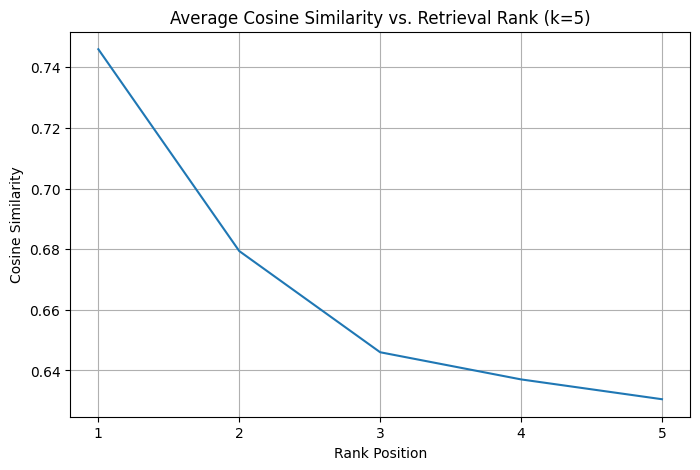

In [ ]:

rank_scores = [[] for _ in range(top_k)]

for res in results:
    docs_scores = res['retrieved_docs']
    for rank, (doc, score) in enumerate(docs_scores):
        
        # convert to similarity
        similarity = 1 - score
        rank_scores[rank].append(similarity)

# calculate mean
avg_scores_per_rank = [np.mean(scores) for scores in rank_scores]
ranks = list(range(1, top_k + 1))


plt.figure(figsize=(8, 5))
plt.plot(ranks, avg_scores_per_rank)
plt.title(f'Average Cosine Similarity vs. Retrieval Rank (k={top_k})')
plt.xlabel('Rank Position')
plt.ylabel('Cosine Similarity')
plt.xticks(ranks)
plt.grid(True)
plt.show()

### **Reflective Question:** Comment on the trend observed. Is it what we're expecting? Why or why not?
**Answer:**
---
Yes, this is as expected, because as the rank increases, by definition the score must decrease.

### Additional Experiment

Now, invoke the same RAG chain for the same queries, but vary the number of retrieved chunks (k) using the following values:

[1, 10, 20, 50]

In [28]:
top_k_values = [1, 10, 20, 50]
experiment_results = {}

for k in top_k_values:
    print(f"\n***** k = {k} *****\n")
    current_k_answers = []
    
    for query in queries:
        # Retrieve top-k docs and scores
        docs_and_scores = vectorstore.similarity_search_with_score(query, k=k)
        similarities = [1 - score for _, score in docs_and_scores]
        avg_similarity = np.mean(similarities)
        context_text = "\n\n".join([doc.page_content for doc, _ in docs_and_scores])
        
        answer = rag_chain.invoke({
            "context": context_text,
            "question": query
        })

        # Store result for this query
        current_k_answers.append({
            "query": query,
            "avg_similarity": avg_similarity,
            "retrieved_docs": docs_and_scores,
            "answer": answer
        })
        
        print(f"Query: {query}")
        print(f"Answer: {answer}\n")
        print(f"Avg Cosine Sim: {avg_similarity:.4f}\n" + "-"*30 )
        
        time.sleep(5)
        
    experiment_results[k] = current_k_answers


***** k = 1 *****

Query: What section is BPE training from? Also list the examples used for this algorithm in the book.
Answer: Based on the provided context:

*   The BPE algorithm is mentioned in relation to **Fig. 2.6**, suggesting it is discussed in or around **Section 2.6**.
*   The provided context **does not list any examples** used for this algorithm.

Avg Cosine Sim: 0.7036
------------------------------
Query: What formula does the book use for the Minimum Edit Distance algorithm?
Answer: I am sorry, but the provided context does not contain information about the formula used for the Minimum Edit Distance algorithm. It only mentions that the algorithm was named by Wagner and Fischer.

Avg Cosine Sim: 0.8112
------------------------------
Query: What problems are highlighted in the book when dealing with scale in large n-gram models?
Answer: When dealing with scale in large n-gram models, the book highlights that language models can be very large, which leads to **practical 

In [30]:
for k, answers in experiment_results.items():
    print(f"Top-k: {k}")
    for i, res in enumerate(answers):
        print(f"  Query {i+1}: Avg similarity = {res['avg_similarity']:.4f}")
    print("-" * 30)

Top-k: 1
  Query 1: Avg similarity = 0.7036
  Query 2: Avg similarity = 0.8112
  Query 3: Avg similarity = 0.8347
  Query 4: Avg similarity = 0.7067
  Query 5: Avg similarity = 0.6735
------------------------------
Top-k: 10
  Query 1: Avg similarity = 0.6155
  Query 2: Avg similarity = 0.7544
  Query 3: Avg similarity = 0.6567
  Query 4: Avg similarity = 0.5482
  Query 5: Avg similarity = 0.6113
------------------------------
Top-k: 20
  Query 1: Avg similarity = 0.5736
  Query 2: Avg similarity = 0.6984
  Query 3: Avg similarity = 0.6204
  Query 4: Avg similarity = 0.5282
  Query 5: Avg similarity = 0.5915
------------------------------
Top-k: 50
  Query 1: Avg similarity = 0.5245
  Query 2: Avg similarity = 0.6080
  Query 3: Avg similarity = 0.5762
  Query 4: Avg similarity = 0.5002
  Query 5: Avg similarity = 0.5661
------------------------------


### **Reflective Question** How does changing the value of k affect the overall quality of results?

**Answer:**
As k increases, the average similarity of the results decreases, since lower ranked chunks are also included as context.

At lower k (1, 10), the answers were generally unhelpful and were not satisfactory; at higher k, the system was able to answer queries which required a larger context base.

However, the higher the value of k, the greater the uncertainty of results and higher the noise, since less-relevant documenrts are being fetched.

# Task 4: AI-as-a-Judge

In this task, you will design an **LLM-based evaluation and reflection loop** for a Retrieval-Augmented Generation (RAG) system. Your goal is to implement a **Critic–Reflector mechanism** that evaluates, scores, and iteratively improves the performance of your RAG pipeline using the following dataset:

> **Dataset:** [Neural Bridge RAG Dataset](https://huggingface.co/datasets/neural-bridge/rag-dataset-12000)

---

## Objectives:

You will:
1. Implement a **Critic** agent that assesses your RAG model’s answers.  
2. Use a **Reflector** agent to analyze the Critic’s feedback and optimize the RAG Generator’s performance across multiple iterations.  
3. Visualize how the **reward (Critic rating)** evolves as your system self-tunes.

---

## System Components

| Component | Model | Role |
|------------|--------|------|
| **Generator** | Gemini 2.0 Flash | Produces answers using your RAG pipeline |
| **Critic** | Gemini 2.5 Pro | Evaluates Generator’s output and provides rewards |
| **Reflector** | Gemini 2.5 Pro | Adjusts the Generator’s configuration to maximize reward |

---

## Part 1 — Setting Up the Critic

1. Configure an **LLM Critic** using the **Gemini 2.5 Pro** model (or a higher version than your RAG Generator).  
   - Set the **temperature** parameter to `0` for deterministic evaluation.  

2. The Critic should take the following as input:
   - The user query (question)  
   - The retrieved context/documents  
   - The Generator’s response  

3. The Critic must output:
   - An **expected (ideal) answer**
   - A **numerical rating (out of 10)** indicating how well the Generator’s response aligns with the expected output  

4. Use **few-shot prompting** to guide the Critic’s evaluations.  
   - Collect several sample query–retrieval–response–rating pairs by manually evaluating model outputs from the dataset.  
   - Provide these examples in your Critic’s prompt to calibrate its scoring behavior.

> 💡 *Tip:* This few-shot calibration step should be clearly shown in your code before running the evaluation loop.

In [2]:
CRITIC_MODEL = "gemini-2.5-pro"
REFLECTOR_MODEL = "gemini-2.5-pro"

In [3]:
rag_dataset = load_dataset("neural-bridge/rag-dataset-12000")

In [5]:
# 2. Run the Critic with a few examples from the dataset, and evaluate the outputs. 
#    You should cherry-pick the best outputs from the bunch, and use them as your few-shot samples for the following task.

# had little time, so I had an LLM make these few shot examples...sorry :(

fewshot_example1_query = "What is the main limitation of N-gram language models?"
fewshot_example1_context = "The primary limitation of N-gram models is sparsity. As N increases, the number of possible n-grams grows exponentially, making it difficult to estimate probabilities reliably from limited training data."
fewshot_example1_answer = "The main limitation is sparsity. Because the number of parameters grows exponentially with N, it becomes hard to estimate probabilities from limited data."
fewshot_example1_rating = 10
fewshot_example1_explanation = "The answer is accurate, complete, and directly supported by the context."

fewshot_example2_query = "Who introduced the Transformer architecture?"
fewshot_example2_context = "The Transformer architecture was introduced by Vaswani et al. in the 2017 paper 'Attention Is All You Need'. It relies entirely on self-attention mechanisms."
fewshot_example2_answer = "The Transformer was proposed by Yann LeCun in 1998 as an improvement to Convolutional Neural Networks for digit recognition."
fewshot_example2_rating = 1
fewshot_example2_explanation = "The answer is factually incorrect and contradicts the provided context (Vaswani vs LeCun)."

fewshot_example_3_query = "How is the TF-IDF score calculated?"
fewshot_example_3_context = "TF-IDF is calculated as the product of Term Frequency (TF) and Inverse Document Frequency (IDF). TF measures how often a term appears in a document, while IDF downweights terms that appear frequently across the entire corpus."
fewshot_example_3_answer = "It is calculated by multiplying two statistics together that measure how important a word is."
fewshot_example_3_rating = 5
fewshot_example_3_explanation = "The answer is technically true but vague. It fails to name 'Term Frequency' and 'Inverse Document Frequency' or explain what they do, despite that info being in the context."

# Compose few-shot example text
fewshot_examples_text = f"""
Example 1:
Query: {fewshot_example1_query}
Context: {fewshot_example1_context}
Generator answer: {fewshot_example1_answer}
Expected (ideal) answer: {fewshot_example1_answer}
Rating: {fewshot_example1_rating}
Explanation: {fewshot_example1_explanation}

Example 2:
Query: {fewshot_example2_query}
Context: {fewshot_example2_context}
Generator answer: {fewshot_example2_answer}
Expected (ideal) answer: The Transformer was introduced by Vaswani et al. in the 2017 paper 'Attention Is All You Need'.
Rating: {fewshot_example2_rating}
Explanation: {fewshot_example2_explanation}

Example 3:
Query: {fewshot_example_3_query}
Context: {fewshot_example_3_context}
Generator answer: {fewshot_example_3_answer}
Expected (ideal) answer: TF-IDF is calculated as TF * IDF, where TF measures term frequency in a document and IDF downweights common terms across the corpus.
Rating: {fewshot_example_3_rating}
Explanation: {fewshot_example_3_explanation}
"""

In [10]:
# init the critic
critic_system_prompt = """
Evaluate the output of a RAG system, along with the user quey and the contexts.
Your evaluation should output:
1) An expected (ideal) answer for the user query.
2) A **numerical rating (out of 10)** indicating how well the Generator’s response aligns with the expected output.

Use these examples to guide you on how to do this task:
{fewshot_examples_text}


Output should be in a JSON format with keys: expected_answer, rating. Only these two must be output as a JSON object!
"""

critic_user_prompt = """
Evaluate the following RAG system output.

User Query:
{query}

Retrieved Context:
{context}

Generator's Answer:
{generator_answer}

Output ONLY a JSON object with two keys:
- expected_answer: a short, clear ideal answer (1-2 sentences)
- rating: an integer from 0 to 10

"""

In [11]:
critic_prompt_template = ChatPromptTemplate.from_messages([
    ("system", critic_system_prompt),
    ("user", critic_user_prompt)
])

json_parser = JsonOutputParser()
critic_llm = ChatGoogleGenerativeAI(model=CRITIC_MODEL, temperature=0)

critic_chain = critic_prompt_template | critic_llm | json_parser

## Part 2 — Designing the Reflector

The **Reflector** takes as input:
- The original user query  
- The Generator’s response  
- The Critic’s expected response and rating  
- Any other hyperparameters or metrics you deem useful  

Using this information, the Reflector should:
- Modify or tune the Generator’s configuration to **maximize the Critic’s rating (reward)** over time.  
- The Reflector may adjust:
  - The Generator’s **system or user messages** (prompt engineering)  
  - The **text splitter parameters** (e.g., `chunk_size`, `chunk_overlap`)  
  - Any other relevant **retriever or generator hyperparameters** that can improve the RAG pipeline’s accuracy or coherence.

In [12]:
# TODO: Initialize the Reflector
reflector_system_prompt = """You are an expert AI Optimization Engineer for RAG pipelines.
Your goal is to tune hyperparameters to maximize the Critic's rating (target: 10/10).

You can tune two parameters:
1. `k` (integer, 1-10): Number of chunks to retrieve.
2. `system_message` (string): The instruction given to the Generator.

**Analysis Strategy:**
Look at the history of iterations. Compare the **Generator Answer** to the **Critic's Expected Answer**:
- If the Generator missed details present in the Expected Answer -> **Increase `k`** or tell the system to be more detailed.
- If the Generator included facts NOT in the Expected Answer (Hallucination) -> **Restrict the system_message** (e.g., "Stick strictly to context").
- If the Rating is low (0-5) -> Make significant changes.
- If the Rating is high (8-9) -> Make minor refinements.

**Output Format:**
Return ONLY a JSON object with these keys:
{
    "k": <integer>,
    "system_message": "<string>",
    "reasoning": "<brief explanation of why you made these changes based on the history>"
}
"""

reflector_user_prompt = """
Review the optimization history below and suggest the next configuration.

Optimization History:
{history}

Suggest the next configuration (JSON):
"""


In [14]:
reflector_prompt_template = ChatPromptTemplate.from_messages([
    ("system", reflector_system_prompt),
    ("user", reflector_user_prompt)
])


reflector_llm = ChatGoogleGenerativeAI(model=REFLECTOR_MODEL, temperature=0)
reflector_parser = JsonOutputParser()

reflector_chain = reflector_prompt_template | reflector_llm | reflector_parser

## Part 3 — Iterative Optimization Loop

1. Run your **Critic–Reflector feedback loop** for **30 iterations**.  
2. After each iteration:
   - Re-run the Generator with the updated configuration.  
   - Re-evaluate using the Critic.  
   - Record the **reward score** assigned by the Critic.  

3. Plot the **reward progression** over the 30 iterations to visualize how your RAG system improves (or regresses) with reflection-driven optimization.

Had to get an LLM to code this up, was taking too long :(

In [ ]:
# TODO: Integrate the Critic and Reflector with the RAG system, and run the loop


from langchain_core.documents import Document


# first 10 datapoints
dataset_subset = rag_dataset['train'][:10]


print("Indexing subset contexts into temporary VectorStore...")
subset_docs = []
test_queries = []
ground_truths = []

for row in dataset_subset:

    doc = Document(page_content=row['context'], metadata={"source": "rag_dataset"})
    subset_docs.append(doc)
    
    # Store query and answer for evaluation
    test_queries.append(row['question'])
    ground_truths.append(row['answer'])

# Create a new, small vectorstore for this experiment
# (We reuse the hf_embeddings from Task 3)
task4_vectorstore = Chroma.from_documents(
    documents=subset_docs,
    embedding=hf_embeddings,
    collection_metadata={"hnsw:space": "cosine"}
)

# --- 3. Run Optimization Loop ---
iterations = 10 # Running 10 iterations for demonstration
current_config = {
    "k": 1,  # Start suboptimal to show improvement
    "system_message": "You are a helpful assistant."
}

history_log = []
reward_history = []

print(f"\n🚀 Starting Optimization Loop on {len(test_queries)} Dataset Queries...")
print("--------------------------------------------------")

for i in range(iterations):
    iteration_scores = []
    
    # --- Batch Evaluation ---
    # We run the current config on all 10 dataset queries
    for q_idx, query in enumerate(test_queries):
        try:
            # A. Generator Step
            retriever = task4_vectorstore.as_retriever(search_kwargs={"k": int(current_config['k'])})
            
            rag_prompt = ChatPromptTemplate.from_messages([
                ("system", current_config['system_message'] + "\n\nContext:\n{context}"),
                ("human", "{question}"),
            ])
            
            docs = retriever.invoke(query)
            context_text = "\n\n".join([d.page_content for d in docs])
            
            gen_chain = rag_prompt | llm | StrOutputParser()
            generator_answer = gen_chain.invoke({"context": context_text, "question": query})
            
            # B. Critic Step
            # Note: We pass the generated context, but the Critic checks against the GENERATOR'S logic.
            # Ideally, the Critic uses the 'Ground Truth' from the dataset as the 'Expected Answer'
            # But our Critic is designed to generate its own Expected Answer via LLM. 
            # We will stick to the LLM Critic workflow for consistency with the prompt.
            critic_output = critic_chain.invoke({
                "query": query,
                "context": context_text,
                "generator_answer": generator_answer
            })
            
            score = critic_output['rating']
            iteration_scores.append(score)

        except Exception as e:
            print(f"Error on Q{q_idx}: {e}")
            iteration_scores.append(0)

    # Calculate Avg Score for this Config
    avg_score = np.mean(iteration_scores) if iteration_scores else 0
    reward_history.append(avg_score)
    
    print(f"Iter {i+1} | k={current_config['k']} | Avg Score: {avg_score:.2f}/10")

    # Store history for Reflector
    step_summary = {
        "iteration": i + 1,
        "config": current_config.copy(),
        "avg_score": avg_score
    }
    history_log.append(step_summary)

    # --- Reflector Step ---
    if i < iterations - 1:
        # Format history for Reflector
        history_str = ""
        for item in history_log[-3:]:
             history_str += f"\nIter {item['iteration']}: Config={item['config']}, Avg Score={item['avg_score']:.2f}"
        
        try:
            reflector_response = reflector_chain.invoke({"history": history_str})
            
            new_k = int(reflector_response.get('k', current_config['k']))
            # Limit k to the size of our small dataset (10) to avoid errors
            new_k = max(1, min(10, new_k))
            
            current_config = {
                "k": new_k,
                "system_message": reflector_response.get('system_message', current_config['system_message'])
            }
            # print(f"   >>> Reflector Update: k -> {new_k}")
            
        except Exception as e:
            print(f"   Reflector Error: {e}")

# --- Plotting ---
plt.figure(figsize=(10, 6))
plt.plot(range(1, iterations + 1), reward_history, marker='o', color='#FF5722', linewidth=2)
plt.title(f'Optimization on Neural Bridge Dataset ({len(test_queries)} samples)')
plt.xlabel('Iteration')
plt.ylabel('Average Critic Score')
plt.ylim(0, 10.5)
plt.grid(True)
plt.show()on.

#### **Reflective Questions:**

##### 1. Did you see any improvements in the pipeline's performance? Explain why or why not? Explain the general trend of reward progression here.

##### 2. Are LLMs a reliable source for scoring purposes? Explain why did we initialize the temperature value to 0 for these tasks?

##### 3. Which hyperparameters had the most significant impact in optimizing the RAG performance?